In [ ]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mpld3

import subprocess
import socket
import time
import os
import gc
import datetime
import logging

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from common_simulator import *

In [ ]:
def downsample(highres_solution, factor):
    if (len(highres_solution.shape) == 1):
        highres_solution = highres_solution.reshape((1, highres_solution.size))

    assert highres_solution.shape[1] % factor == 0
    ny = highres_solution.shape[0] 
    nx = highres_solution.shape[1] / factor

    if (factor == 1):
        return highres_solution
    else:
        
        return highres_solution.reshape([int(ny), int(1), int(nx), int(factor)]).mean(3).mean(1)

In [ ]:
def wall_boundary_conditions(data, num_ghost_cells):
    data[0:num_ghost_cells,:] = data[2*num_ghost_cells-1:num_ghost_cells-1:-1,:]
    data[-num_ghost_cells:,:] = data[-num_ghost_cells-1:-2*num_ghost_cells-1:-1,:]
    data[:,0:num_ghost_cells] = data[:,2*num_ghost_cells-1:num_ghost_cells-1:-1]
    data[:,-num_ghost_cells:] = data[:,-num_ghost_cells-1:-2*num_ghost_cells-1:-1]
    return data

In [ ]:
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
domain_sizes = np.loadtxt('domain_sizes.csv').transpose().astype(int)

# Space calculations

In [ ]:
ic = 'bump'
for simulator in simulators:
    commands = 'python calculator_simulator.py'.split(' ')
    commands += ['space']
    commands += [ic]
    commands += [simulator.__name__]
    commands += f'--ref {gen_filename(None, nx=domain_sizes[-1][0], ny=domain_sizes[-1][1], prefix="space", ic=ic, simulator=simulator.__name__)}'.split(' ')
    commands += ['--sizes']
    commands += [f'{nx}_{ny}' for nx,ny in domain_sizes]
    print(commands)
    subprocess.run(commands)

['python', 'calculator_simulator.py', 'space', 'bump', 'LxF', '--ref', '/home/aadi.bhure/Code-pk/FiniteVolumeGPU/space_data/bump/LxF_4096_4096.npz', '--sizes', '8_8', '16_16', '32_32', '64_64', '128_128', '256_256', '512_512', '1024_1024', '2048_2048', '4096_4096']
Created space_data/results/bump/LxF.npz
['python', 'calculator_simulator.py', 'space', 'bump', 'FORCE', '--ref', '/home/aadi.bhure/Code-pk/FiniteVolumeGPU/space_data/bump/FORCE_4096_4096.npz', '--sizes', '8_8', '16_16', '32_32', '64_64', '128_128', '256_256', '512_512', '1024_1024', '2048_2048', '4096_4096']
Created space_data/results/bump/FORCE.npz
['python', 'calculator_simulator.py', 'space', 'bump', 'HLL', '--ref', '/home/aadi.bhure/Code-pk/FiniteVolumeGPU/space_data/bump/HLL_4096_4096.npz', '--sizes', '8_8', '16_16', '32_32', '64_64', '128_128', '256_256', '512_512', '1024_1024', '2048_2048', '4096_4096']
Created space_data/results/bump/HLL.npz
['python', 'calculator_simulator.py', 'space', 'bump', 'HLL2', '--ref', '/ho

# Time calculations

In [ ]:
for simulator in simulators:
    commands = 'python calculator_simulator.py'.split(' ')
    commands += ['time']
    commands += ['bump']
    commands += [simulator.__name__]
    commands += ['--sizes']
    commands += [f'{nx}_{ny}' for nx,ny in domain_sizes]
    print(commands)
    subprocess.run(commands, check=True)

['python', 'calculator_simulator.py', 'time', 'bump', 'LxF', '--sizes', '8_8', '16_16', '32_32', '64_64', '128_128', '256_256', '512_512', '1024_1024', '2048_2048', '4096_4096']
Created time_data/results/bump/LxF.npz
['python', 'calculator_simulator.py', 'time', 'bump', 'FORCE', '--sizes', '8_8', '16_16', '32_32', '64_64', '128_128', '256_256', '512_512', '1024_1024', '2048_2048', '4096_4096']
Created time_data/results/bump/FORCE.npz
['python', 'calculator_simulator.py', 'time', 'bump', 'HLL', '--sizes', '8_8', '16_16', '32_32', '64_64', '128_128', '256_256', '512_512', '1024_1024', '2048_2048', '4096_4096']
Created time_data/results/bump/HLL.npz
['python', 'calculator_simulator.py', 'time', 'bump', 'HLL2', '--sizes', '8_8', '16_16', '32_32', '64_64', '128_128', '256_256', '512_512', '1024_1024', '2048_2048', '4096_4096']
Created time_data/results/bump/HLL2.npz
['python', 'calculator_simulator.py', 'time', 'bump', 'KP07', '--sizes', '8_8', '16_16', '32_32', '64_64', '128_128', '256_256

# Plots!

### Load data

In [ ]:
time_ds_x, time_ds_y = [], []
space_ds_x, space_ds_y = [], []
secs_per_timestep = []
megacells_per_sec = []
sim_errors = []
sim_cons = []
sim_nt = []
longsim_nt = []
longsim_tf = []
sim_tf = []

for  i, simulator in enumerate(simulators):
    # time data
    filename = gen_results_filename('time', simulator.__name__, 'bump')
    with np.load(filename) as d:
        order = np.argsort(d['ds_x'])
        time_ds_x.append(d['ds_x'][order])
        time_ds_y.append(d['ds_y'][order])
        secs_per_timestep.append(d['secs_per_timestep'][order])
        megacells_per_sec.append(d['megacells_per_sec'][order])
        longsim_nt.append(d['sim_nt'])
        longsim_tf.append(d['sim_tf'][order])

    filename = gen_results_filename('space', simulator.__name__, 'bump')
    # space data
    with np.load(filename) as d:
        order = np.argsort(d['ds_x'])
        space_ds_x.append(d['ds_x'][order])
        space_ds_y.append(d['ds_y'][order])
        sim_errors.append(d['sim_errors'][order])
        sim_cons.append(d['sim_cons'][order])
        sim_nt.append(d['sim_nt'][order])
        sim_tf.append(d['sim_tf'])

# Reduce orders for redundant data
time_ds_x = np.array(time_ds_x)
time_ds_y = np.array(time_ds_y)
space_ds_x = np.array(space_ds_x)
space_ds_y = np.array(space_ds_y)
assert np.all(time_ds_x == space_ds_x) 
assert np.all(time_ds_y == space_ds_y) 
assert np.all(time_ds_x == time_ds_x[0]) 
assert np.all(time_ds_y == time_ds_y[0]) 
ds_x = time_ds_x[0]
ds_y = time_ds_y[0]

assert np.all(longsim_nt == longsim_nt[0])
assert np.all(sim_tf == sim_tf[0])
longsim_nt = longsim_nt[0]
sim_tf = sim_tf[0]

secs_per_timestep = np.array(secs_per_timestep)
megacells_per_sec = np.array(megacells_per_sec)
sim_errors = np.array(sim_errors)
sim_cons = np.array(sim_cons)
sim_nt = np.array(sim_nt)
longsim_tf = np.array(longsim_tf)

gc.collect()

572

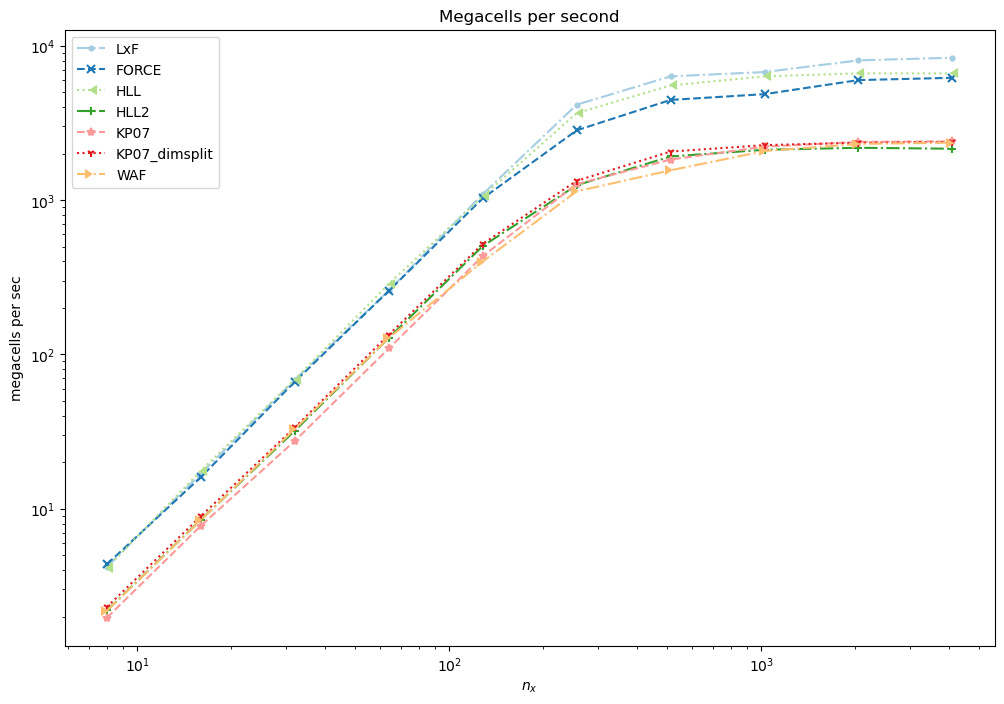

In [ ]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.loglog(ds_x, megacells_per_sec[i], label = simulator.__name__)
    plt.xlabel("$n_x$")
    plt.ylabel("megacells per sec")
plt.legend()
plt.title("Megacells per second")
miscPlotting.save_figure(fig, "megacells per second")

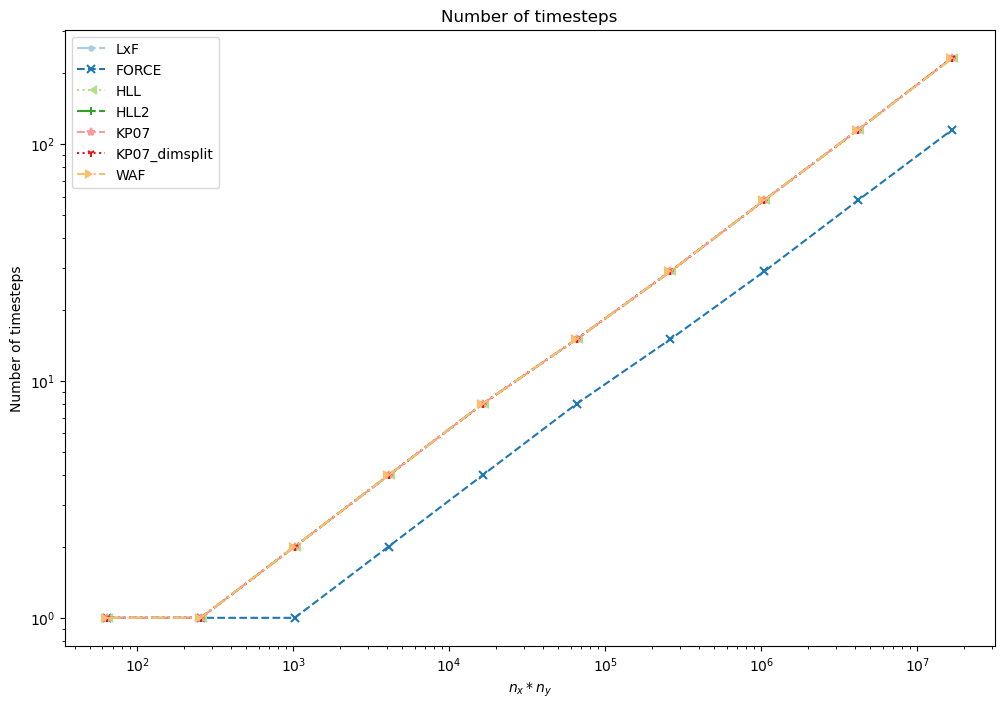

In [ ]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.loglog(ds_x * ds_y, sim_nt[i], label = simulator.__name__)
    plt.xlabel("$n_x * n_y$")
    plt.ylabel("Number of timesteps")
plt.legend()
plt.title("Number of timesteps")
miscPlotting.save_figure(fig, "number_of_timesteps", ic)

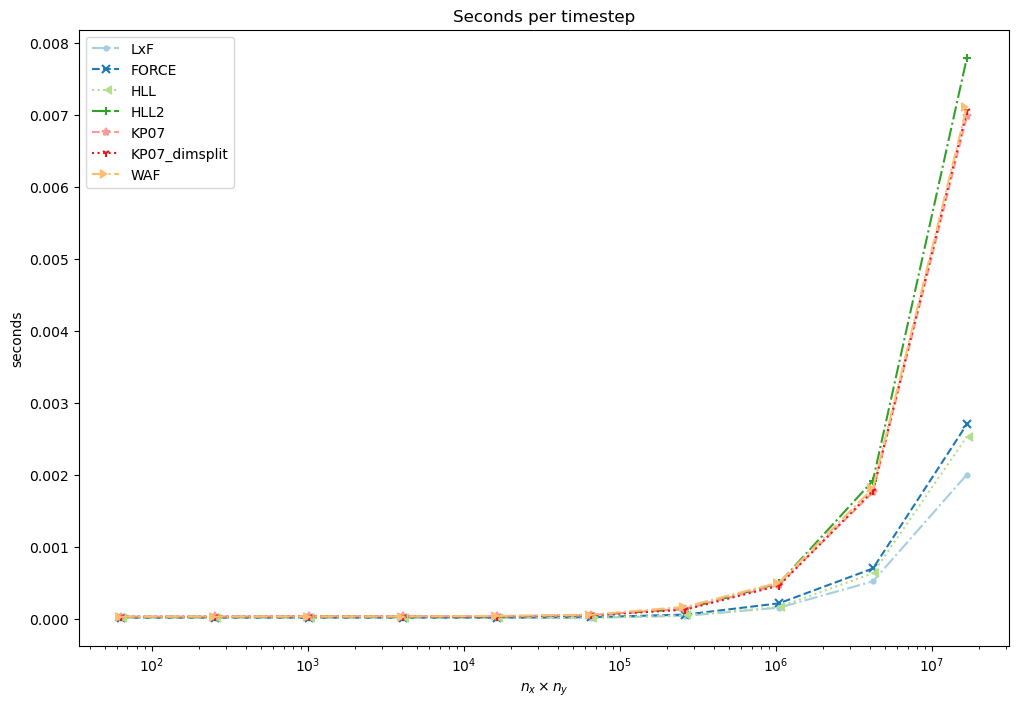

In [ ]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.semilogx(ds_x * ds_y, secs_per_timestep[i], label = simulator.__name__)
    plt.xlabel("$n_x \\times n_y$")
    plt.ylabel("seconds")
plt.legend()
plt.title("Seconds per timestep")
miscPlotting.save_figure(fig, "seconds_per_timestep", ic)

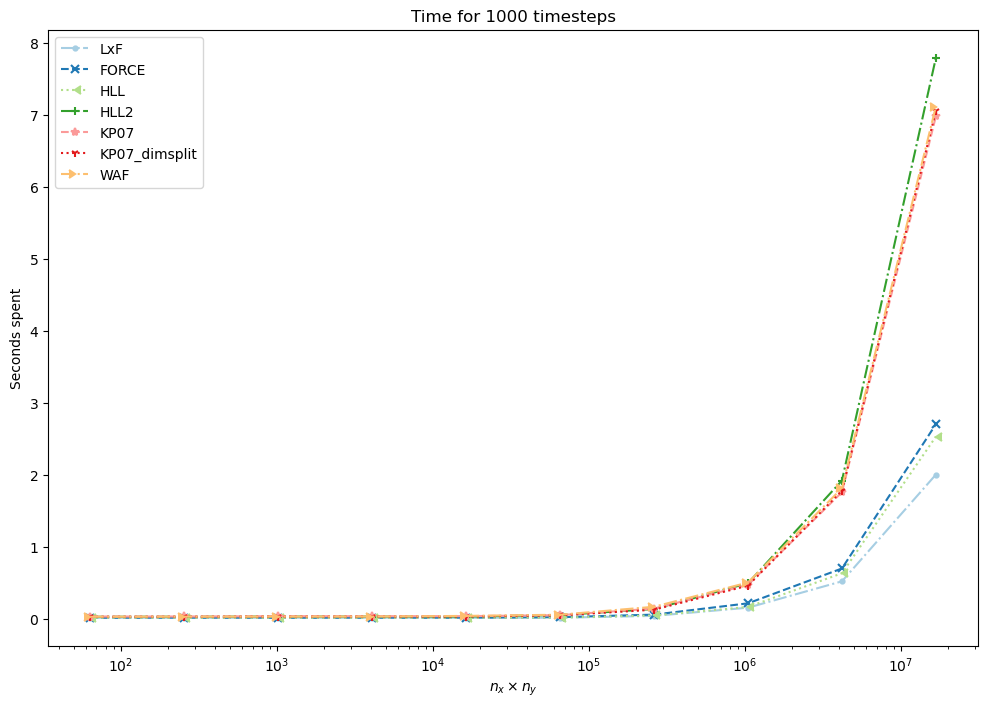

In [ ]:
longsim_elapsed_time = np.array(secs_per_timestep) * longsim_nt
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.semilogx(ds_x * ds_y, longsim_elapsed_time[i,:], label = f"{simulator.__name__}")
    plt.xlabel("$n_x\\times n_y$")
    plt.ylabel("Seconds spent")
plt.legend()
plt.title(f"Time for {longsim_nt.astype(int)} timesteps")
miscPlotting.save_figure(fig, "longtime_spent", ic)

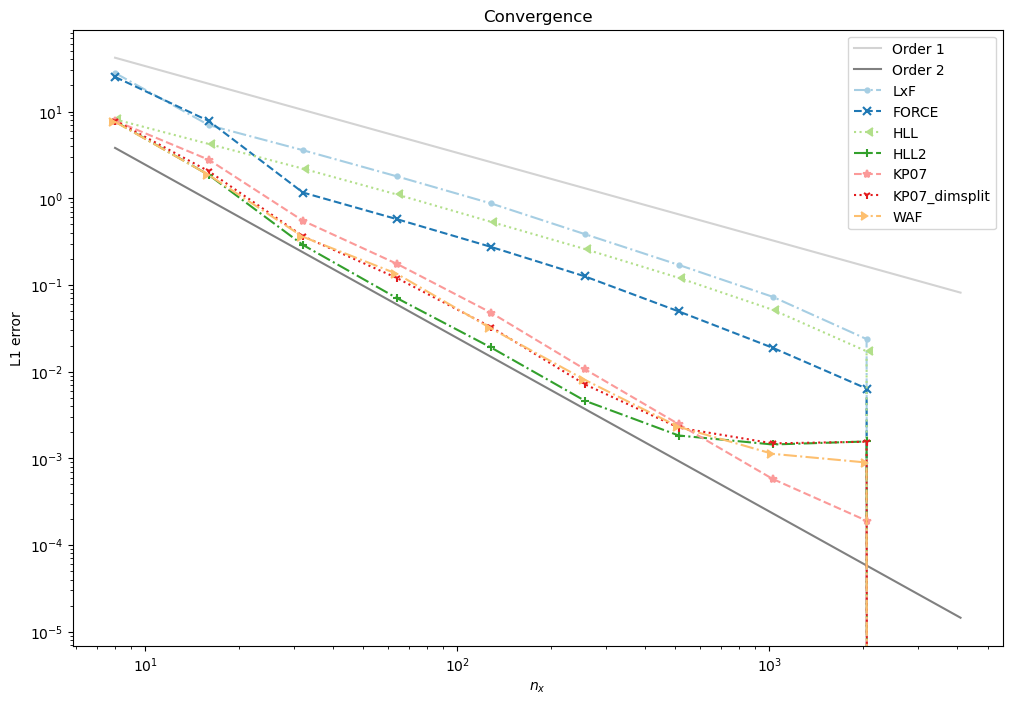

In [ ]:
dxs = np.sqrt(ds_x * ds_y)

import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()
scaling = np.max(sim_errors[:,0]) * 1.5 * dxs[0]
plt.plot(dxs, scaling / np.array(dxs), '-', c='lightgray', label='Order 1')
scaling = np.min(sim_errors[:,0]) * 0.5 * dxs[0] ** 2
plt.plot(dxs, scaling / np.power(dxs, 2), '-', c='gray', label='Order 2')

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.loglog(dxs, sim_errors[i,:], label = simulator.__name__)
    plt.xlabel("$n_x$")
    plt.ylabel("L1 error")
plt.legend()
plt.title("Convergence")
miscPlotting.save_figure(fig, "convergence_rate_all", ic)

## Time vs absolute error plot

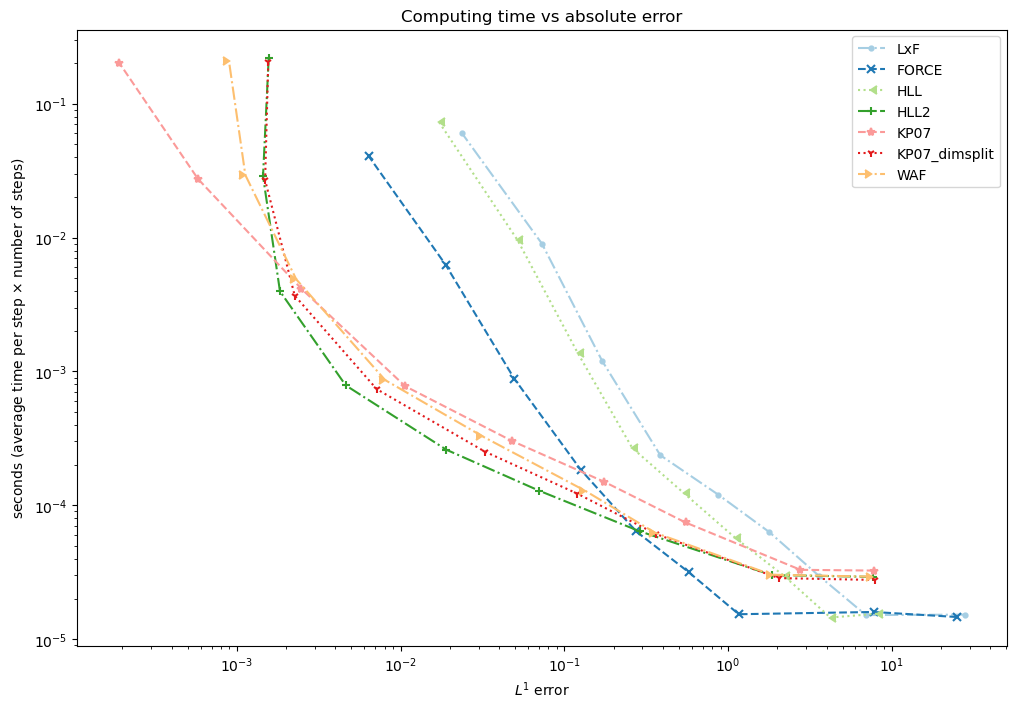

In [ ]:
# Plot the timing and error data
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()
miscPlotting.setBwStyles(fig.gca())
plt.title("Computing time vs absolute error")

for i, simulator in enumerate(simulators):
    plt.loglog(sim_errors[i,:-1], secs_per_timestep[i,:-1] * sim_nt[i,:-1], label = simulator.__name__)
    plt.xlabel("$L^1$ error")
    plt.ylabel("seconds (average time per step $\\times$ number of steps)")

plt.legend()
miscPlotting.save_figure(fig, "time_to_solution", ic)

## Solution plots

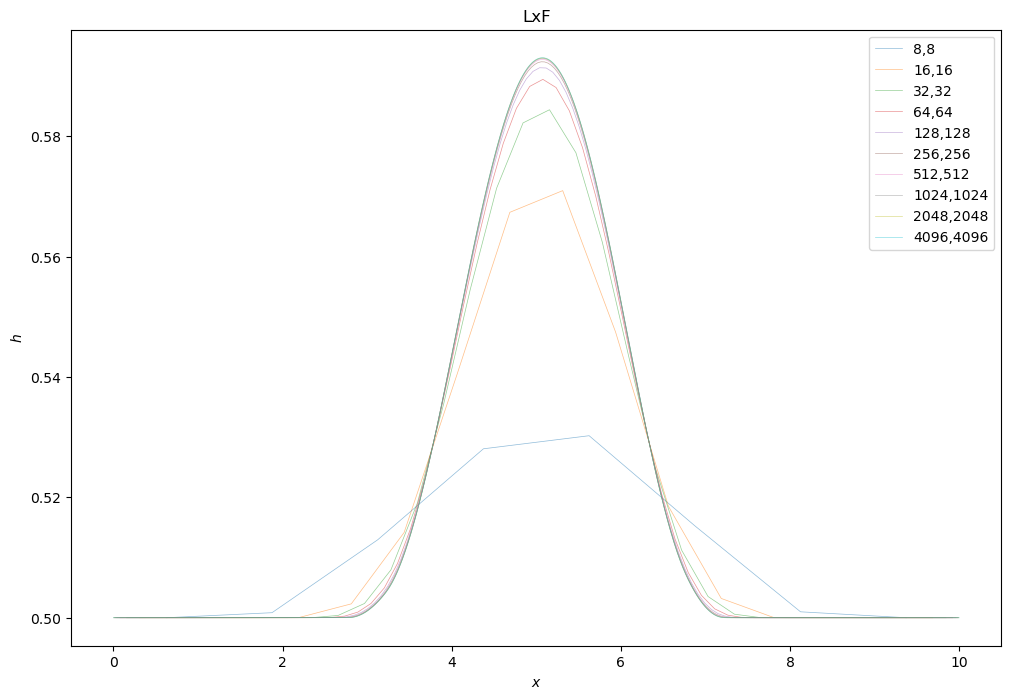

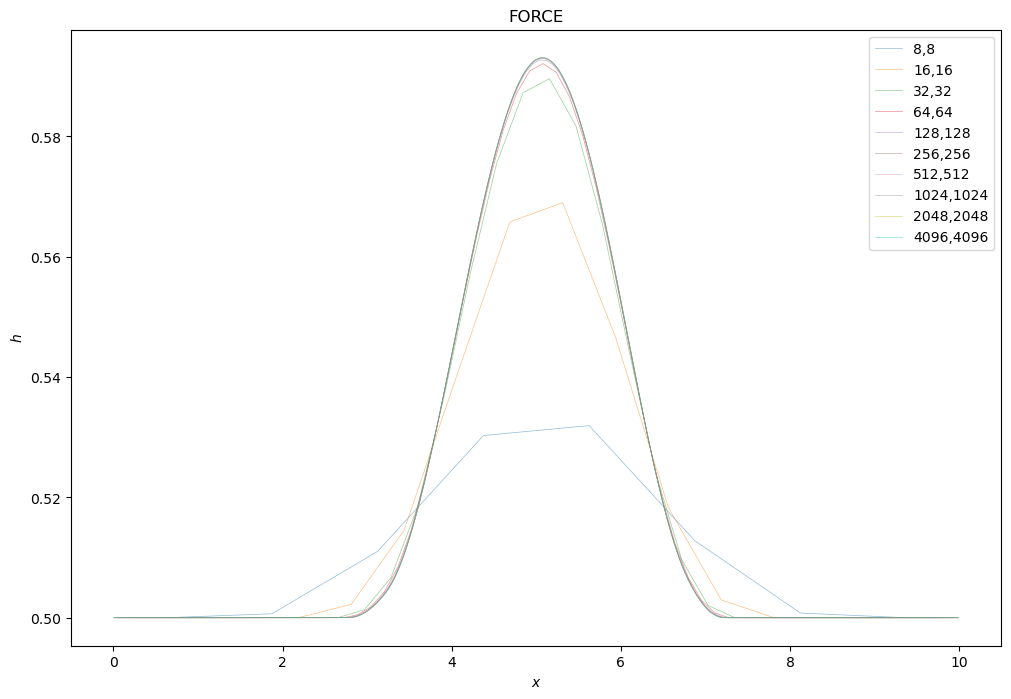

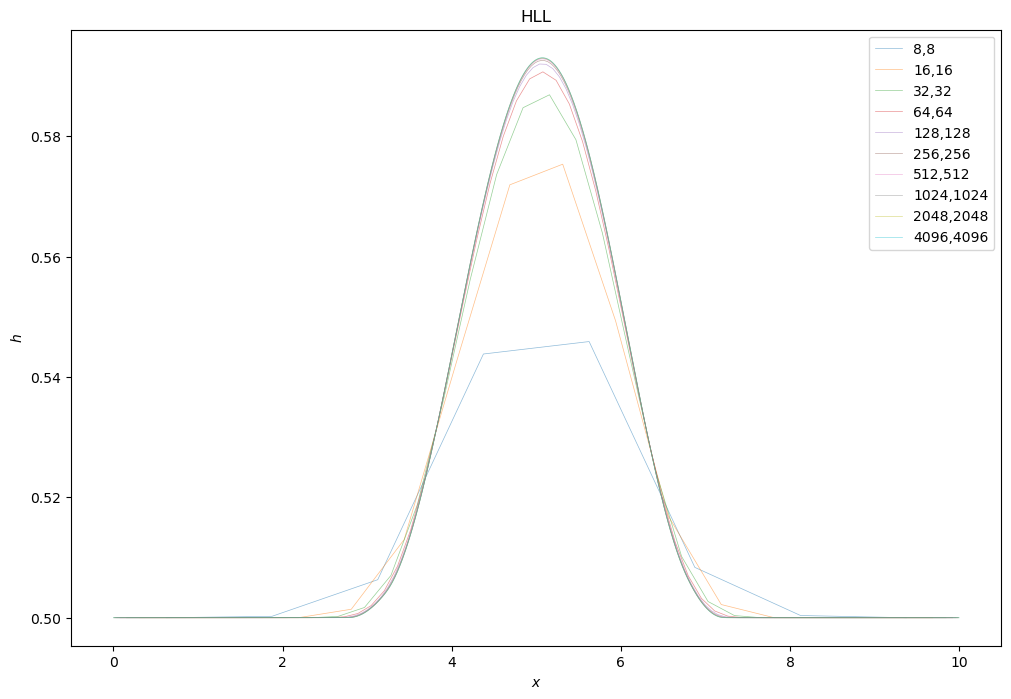

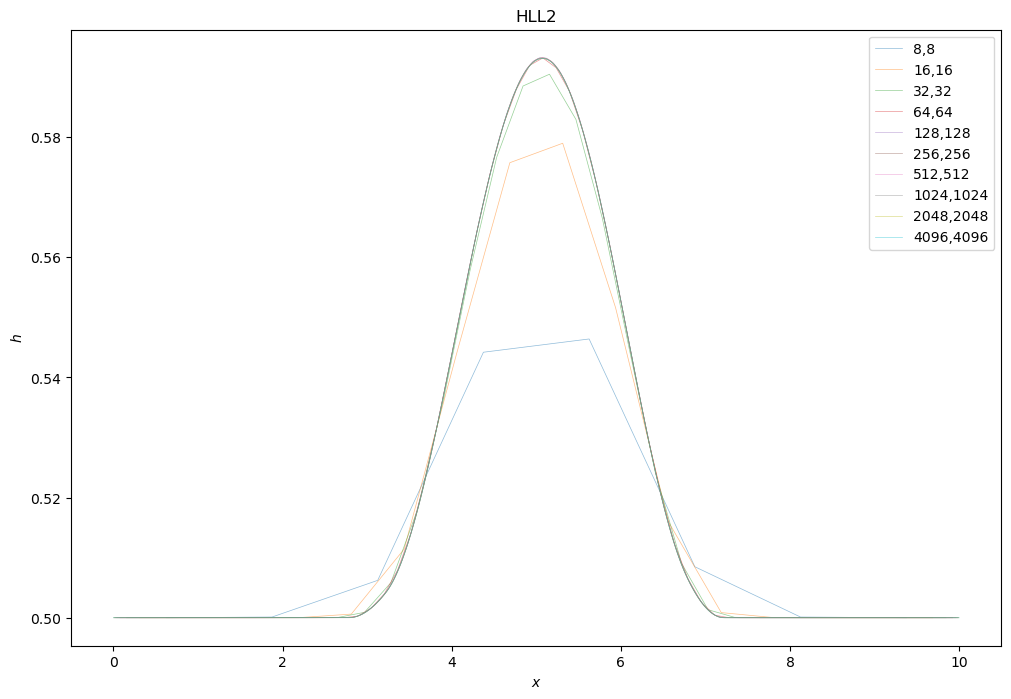

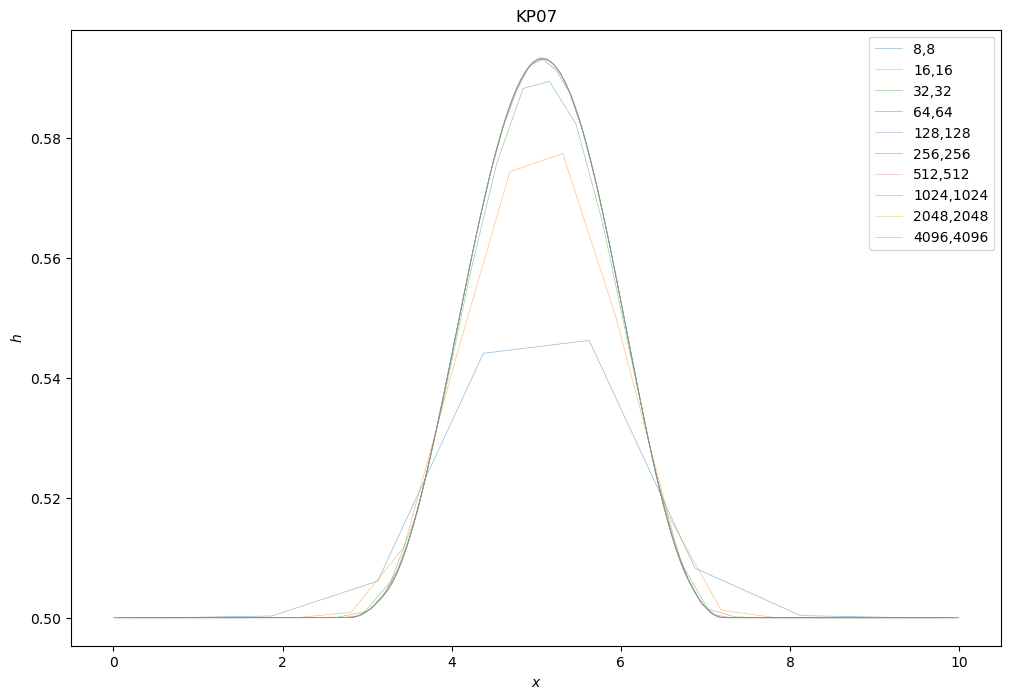

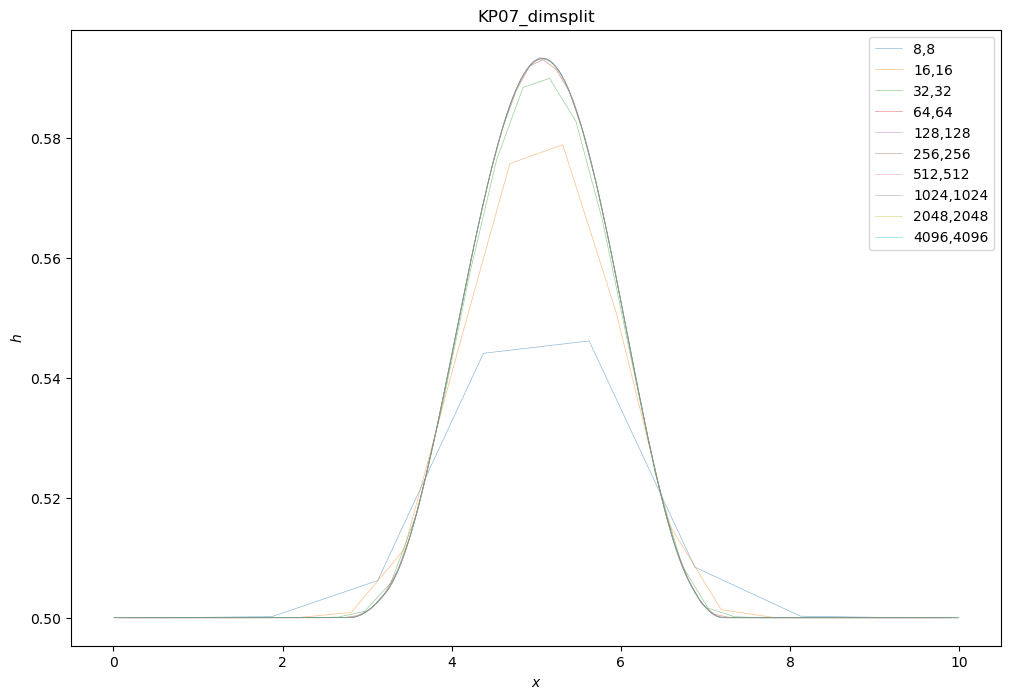

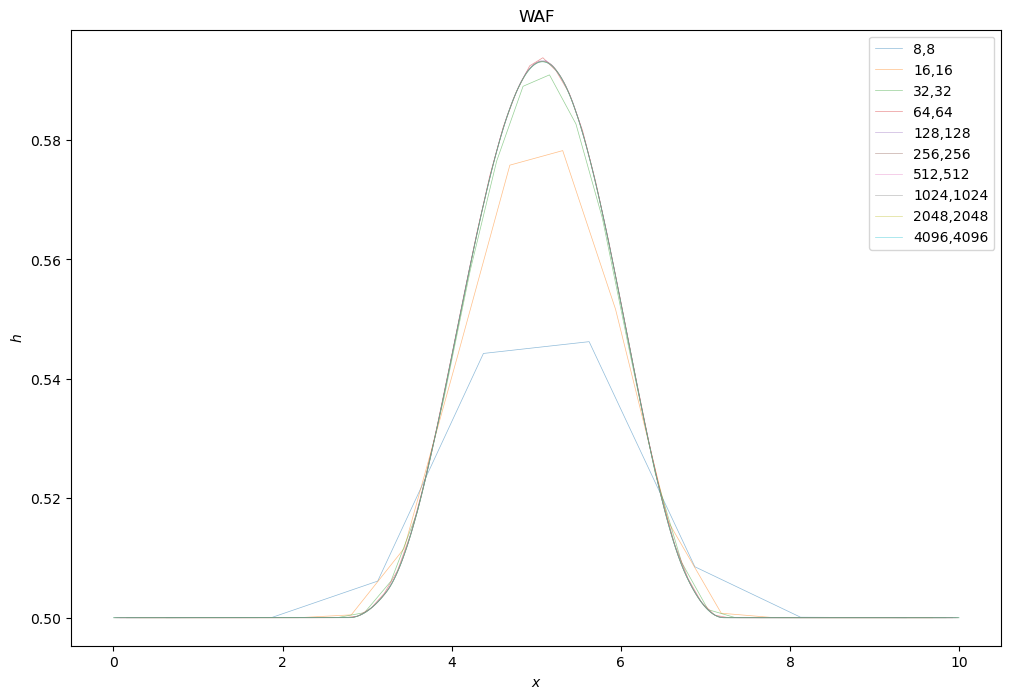

In [ ]:
def plot_solution(simulator, nx, ny, label, **kwargs):
    datafilename = gen_filename(None, nx, ny, ic=ic, simulator=simulator.__name__, prefix='space')
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        
    x = np.linspace(0.5, nx-0.5, nx)*10.0/float(nx)
    y = h[int(h.shape[1]/2),:]
    
    plt.plot(x, y, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force 

for i, simulator in enumerate(simulators):
    fig = plt.figure()
    # miscPlotting.setBwStyles(fig.gca())
#    plot_solution(simulator, ref_nx, label=str(ref_nx) +" (ref)", c='k', ls='dotted', marker=None, lw=1, alpha=0.5)
    for size in domain_sizes:
#        fig.set_prop_cycle(cycler('color', miscPlotting.sns.color_palette()))
        plot_solution(simulator, size[0], size[1], label=str(size[0]) + ',' + str(size[1]), marker=None, lw=0.5, alpha=0.5)
    plt.xlabel("$x$")
    plt.ylabel("$h$")
    plt.legend()
    plt.title(simulator.__name__)
#    miscPlotting.save_figure(fig, f" solution_{simulator.__name__}", ic)